ncpus = 62
      LC_Class_I       blue_0      blue_1      blue_2      blue_3      blue_4  \
0           11.0   529.745911  425.562042  395.205750  494.550720  651.716431   
1           11.0   596.239380  305.712250  289.039215  474.566345  533.318054   
2           11.0   536.000000  388.000153  366.960999  337.208557  627.650757   
3           11.0   364.504913  412.823730  313.134521  400.042450  512.982666   
4           11.0   654.629395  568.343140  444.973511  536.012695  631.338501   
...          ...          ...         ...         ...         ...         ...   
5134        75.0   791.843445  417.563599  419.727112  498.129211  617.616699   
5135        75.0   501.830078  368.868805  339.254242  350.385437  431.580902   
5136        75.0   691.823914  404.275665  345.137024  552.436890  951.995544   
5137        75.0   665.847717  383.261963  323.719177  427.327148  716.235046   
5138        75.0  2287.999756  331.279755  321.187408  356.032837  464.932434   

          blue_5

Text(0.5, 0, 'Variable')

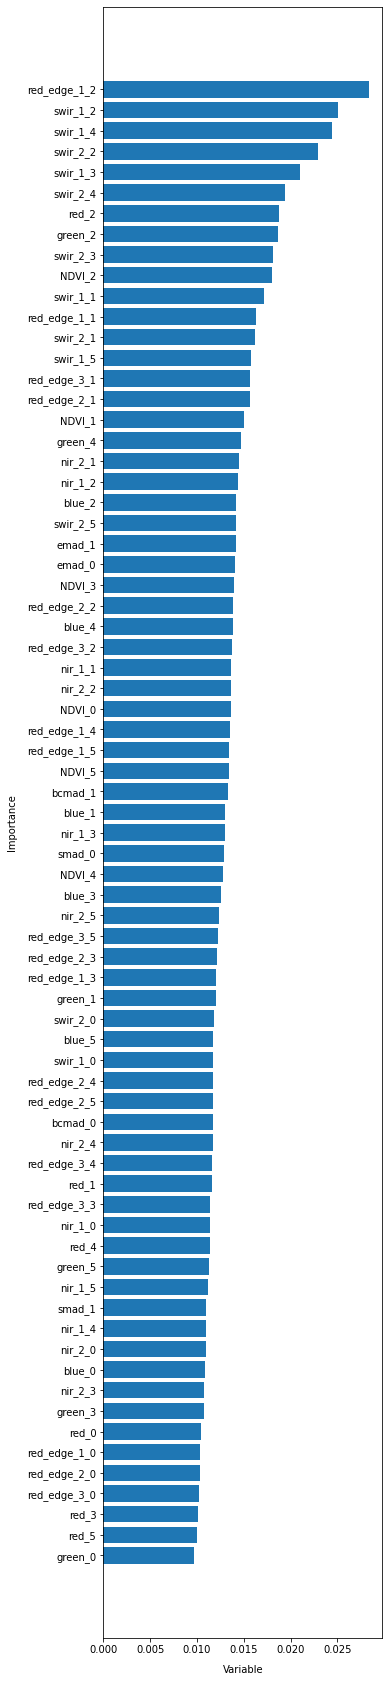

In [11]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import  precision_score, recall_score
from joblib import dump

ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

# file paths and attributes
# dict_map={1:'Dense Forest',2:'Open Forest',6:'Open Grassland',8:'Wooded Grassland',10:'Cropland',11:'Vegetated Wetland',12:'Open Water',13:'Settlements'}
# dict_map={1:'Water',2:'Cropland',3:'Trees',4:'Bare Surface',5:'Shrubland/Grassland'}
dict_map={11:'tree cultivation',12:'non-tree cultivation',21:'forest plantations',31:'Grassland',
          33:'Wooded grassland',42:'wetlands?',44:'Water body',51:'Urban',61:'Bare ground',62:'Rock without vegetation?',
          70:'Mangrove',71:'Lebombo ironwood?',72:'Closed Mountain forest',73:'Enclosed Evergreen Forest',
          74: 'Closed Semi-Deciduous Forest',75:'Mopane',77:'Open Evergreen Forest',79:'Open Semi-Deciduous Forest'}


# training_data='Results/stratified_random_training_points_lulc_2016_balanced_2021_filtered_removing_nans.txt'
training_data='Results/stratified_random_training_points_lulc_2016_balanced_2021_filtered_removing_nans_with_MADs.txt'
measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','nir_2','swir_1','swir_2','NDVI']
measurements_MAD=['smad','emad','bcmad']
class_name = 'LC_Class_I' # class label in integer format
column_names=[class_name]
for measurement in measurements:
    for i in range(6):
        column_names.append(measurement+'_'+str(i))
for measurement in measurements_MAD:
    for i in range(2):
        column_names.append(measurement+'_'+str(i))
# load training data as dataframe
df_training_data= pd.read_csv(training_data,delimiter=' ')
df_training_data=df_training_data[column_names]
print(df_training_data)

# merge classes
df_training_data.loc[df_training_data[class_name]==62,class_name]=61 # rock without vegetation (62) merged with Bare ground (61)
df_training_data.loc[df_training_data[class_name]==11,class_name]=12 # tree cultivation (11) merged with non-tree cultivation (12)
# df_training_data.loc[df_training_data[class_name]==77,class_name]=73 # Open Evergreen Forest (77) merged with Enclosed Evergreen Forest (73)
# merge forest classes as one (except Mangrove)
df_training_data.loc[(df_training_data[class_name]==79)|(df_training_data[class_name]==77)|(df_training_data[class_name]==72)
                     |(df_training_data[class_name]==75)|(df_training_data[class_name]==73)|(df_training_data[class_name]==33)|(df_training_data[class_name]==21),class_name]=74

# remove NaNs which were somehow export as zeros during extraction of training data
df_training_data=df_training_data.loc[(df_training_data!=0).all(axis=1)].reset_index(drop=True)
print('training data after removing nans\n',df_training_data)

# convert to numpy array
model_input=df_training_data.to_numpy()

# fit classifier using all features
rf=RandomForestClassifier(n_estimators=100,max_samples=0.5,min_samples_leaf=1,bootstrap=True)
rf.fit(model_input[:,1:],model_input[:,0])

# # grid search to find optimal random forest classifier hyperparameters
# cv=model_selection.StratifiedShuffleSplit(n_splits=5,random_state=1) # stratified shuffle K-fold splitting
# rf = RandomForestClassifier()
# grid_parameters={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 15)],
#                  'max_samples':[0.3,0.5,1],'min_samples_split':[2,4,8],'max_features': ['sqrt', 'log2'],
#                 'class_weight':['balanced', None]}
# print('Grid searching best hyper-parameters...')
# grid_search=model_selection.GridSearchCV(estimator = rf,param_grid=grid_parameters,cv=cv,n_jobs=ncpus)
# grid_search.fit(model_input[:,1:],model_input[:,0])
# print('Optimal parameters: \n',grid_search.best_params_)
# rf = RandomForestClassifier(**grid_search.best_params_, random_state=1, n_jobs=ncpus)
# # fit classifier using all features and the optimised hyperparameters
# rf.fit(model_input[:,1:],model_input[:,0]) 

# most important features
feat_importance_indices=np.argsort(rf.feature_importances_)[-10:]
print('most importance features: \n',df_training_data.columns[1:][feat_importance_indices])
plt.figure(figsize=(5,30))
order=np.argsort(rf.feature_importances_)
plt.barh(y=np.array(df_training_data.columns[1:])[order],width=rf.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10)
# save the model
# dump(rf, 'Results/RF_model_Mozambique_2017.joblib')
# dump(rf, 'Results/RF_model_Mozambique_2021.joblib')

# # fit model using selected features
# # feat_importance_indices=[]
# # rf = RandomForestClassifier(n_estimators=100,max_samples=0.5,min_samples_leaf=1,bootstrap=True)
# model_input_selected=np.concatenate((model_input[:,[0]],model_input[:,1:][:,feat_importance_indices]),axis=1)
# print(np.all(model_input_selected[:,1:]==model_input[:,1:][:,feat_importance_indices]))
# print(np.all(model_input[:,0]==model_input_selected[:,0]))
# rf.fit(model_input[:,1:][:,feat_importance_indices],model_input[:,0])
# # dump(rf, 'Results/RF_model_feature_selection_Mozambique_2021.joblib')
# # dump(rf, 'Results/RF_model_feature_selection_Mozambique_2017.joblib')

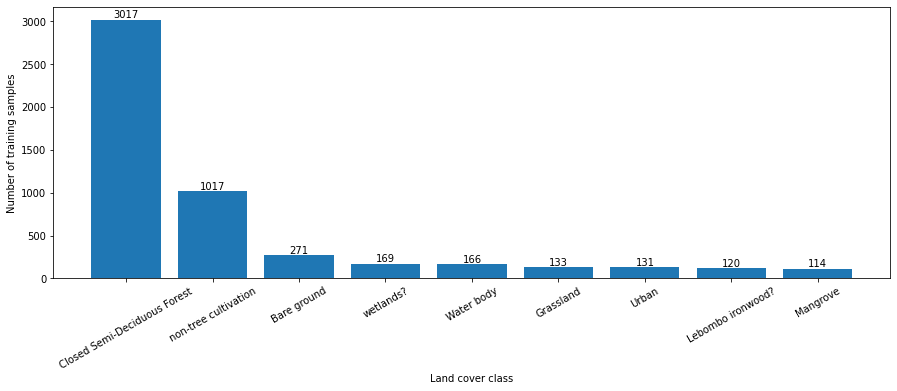

In [12]:
class_counts=df_training_data[class_name].value_counts()
class_indices=class_counts.index
class_legends=[dict_map[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Land cover class')
plt.gca().tick_params(axis='x', rotation=30)

Overall accuracy from cv scores:  0.6769173937917474
f1_macro from cv scores:  0.4627210079405857
Overall accuracy from cv:  0.678864813460686
Overall accuracy from cv predict:  0.6798365122615804
Precision for each class: 
 {'tree cultivation': 0.0, 'non-tree cultivation': 0.483, 'forest plantations': 0.0, 'Grassland': 0.0, 'Wooded grassland': 0.0, 'wetlands?': 0.5, 'Water body': 0.896, 'Urban': 0.46, 'Bare ground': 0.699, 'Rock without vegetation?': 0.0, 'Mangrove': 0.83, 'Lebombo ironwood?': 0.905, 'Closed Mountain forest': 0.0, 'Enclosed Evergreen Forest': 0.0, 'Closed Semi-Deciduous Forest': 0.698, 'Mopane': 0.0, 'Open Evergreen Forest': 0.0, 'Open Semi-Deciduous Forest': 0.0}
Recall for each class: 
 {'tree cultivation': 0.0, 'non-tree cultivation': 0.302, 'forest plantations': 0.0, 'Grassland': 0.0, 'Wooded grassland': 0.0, 'wetlands?': 0.041, 'Water body': 0.777, 'Urban': 0.176, 'Bare ground': 0.266, 'Rock without vegetation?': 0.0, 'Mangrove': 0.772, 'Lebombo ironwood?': 0.558

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


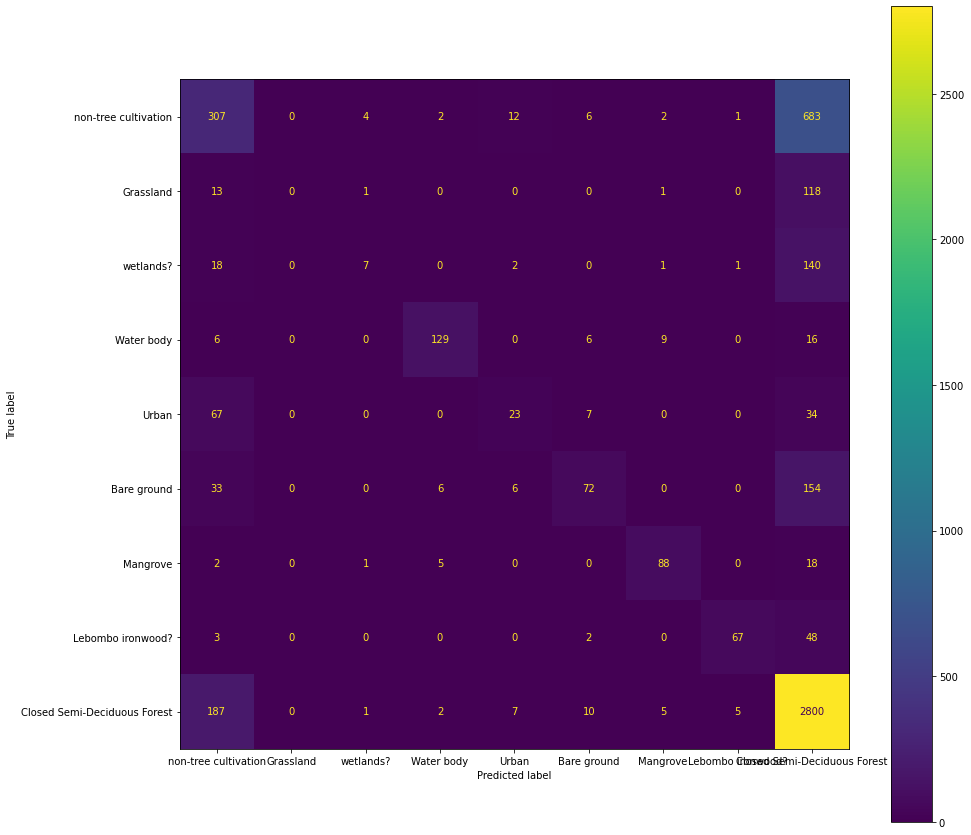

In [14]:
model_input_selected=model_input
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
# skf=model_selection.StratifiedKFold(n_splits=5,shuffle=False) # stratified K-fold splitting
overall_acc=model_selection.cross_val_score(rf,model_input_selected[:,1:],model_input_selected[:,0],cv=skf,scoring='accuracy')
print('Overall accuracy from cv scores: ',np.mean(overall_acc))
f1_macro=model_selection.cross_val_score(rf,model_input_selected[:,1:],model_input_selected[:,0],cv=skf,scoring='f1_macro')
print('f1_macro from cv scores: ',np.mean(f1_macro))
# print('Overall accuracy: ',np.mean(overall_acc)*100,'%')
cv_results=model_selection.cross_validate(rf,model_input_selected[:,1:],model_input_selected[:,0],cv=skf)
print('Overall accuracy from cv: ',np.mean(cv_results['test_score']))
predictions=model_selection.cross_val_predict(rf,model_input_selected[:,1:],model_input_selected[:,0],cv=skf)
print('Overall accuracy from cv predict: ',accuracy_score(model_input_selected[:, 0],predictions))

values=list(dict_map.keys())
precision=precision_score(model_input_selected[:,0],predictions,labels=values,average=None)
print('Precision for each class: \n',dict(zip([dict_map[value] for value in values],np.around(precision,3))))

recall=recall_score(model_input_selected[:,0],predictions,labels=values,average=None)
print('Recall for each class: \n',dict(zip([dict_map[value] for value in values],np.around(recall,3))))

cm=confusion_matrix(model_input_selected[:, 0], predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[dict_map[rf.classes_[i]] for i in range(len(rf.classes_))])
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

Training data shape: (1888, 67)
Testing data shape: (473, 67)
Overall accuracy:  67.44186046511628 %
Balanced accuracy:  57.25813256102984 %
Kappa coefficient:  0.4407266361598231
Confusion matrix:

Training data shape: (1889, 67)
Testing data shape: (472, 67)
Overall accuracy:  71.82203389830508 %
Balanced accuracy:  62.373822256175195 %
Kappa coefficient:  0.5171448350126913
Confusion matrix:

Training data shape: (1889, 67)
Testing data shape: (472, 67)
Overall accuracy:  69.70338983050848 %
Balanced accuracy:  64.19476915839735 %
Kappa coefficient:  0.48972587205346485
Confusion matrix:

Training data shape: (1889, 67)
Testing data shape: (472, 67)
Overall accuracy:  67.37288135593221 %
Balanced accuracy:  59.72885851955072 %
Kappa coefficient:  0.4438646692476015
Confusion matrix:

Training data shape: (1889, 67)
Testing data shape: (472, 67)
Overall accuracy:  70.33898305084746 %
Balanced accuracy:  63.388441777206616 %
Kappa coefficient:  0.5018206765528523
Confusion matrix:

me

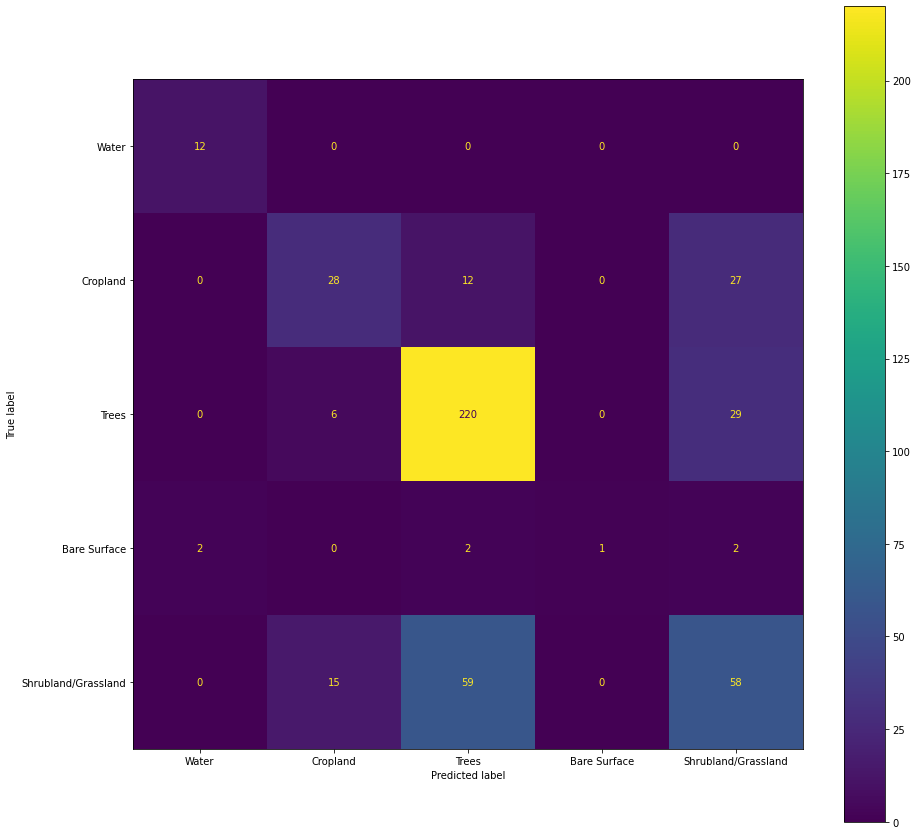

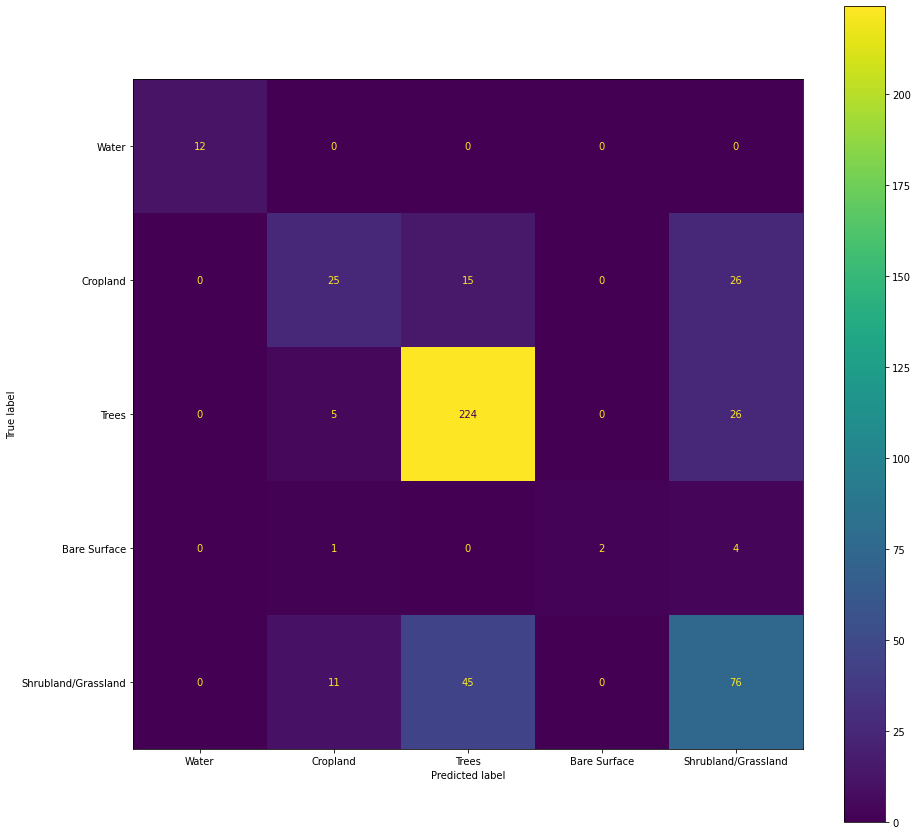

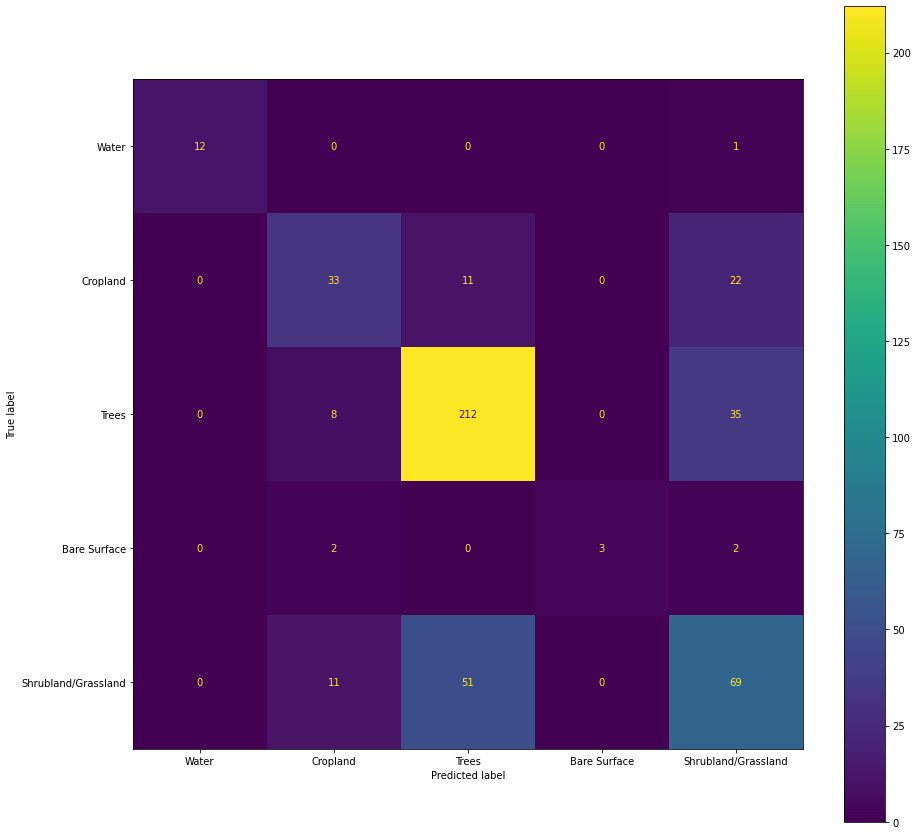

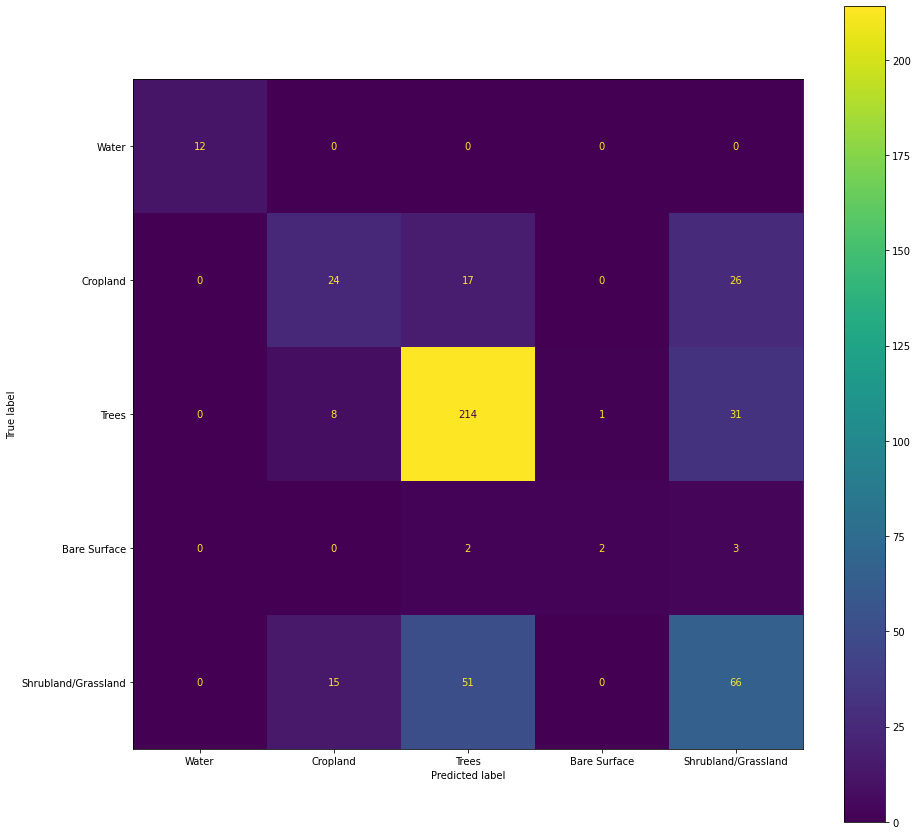

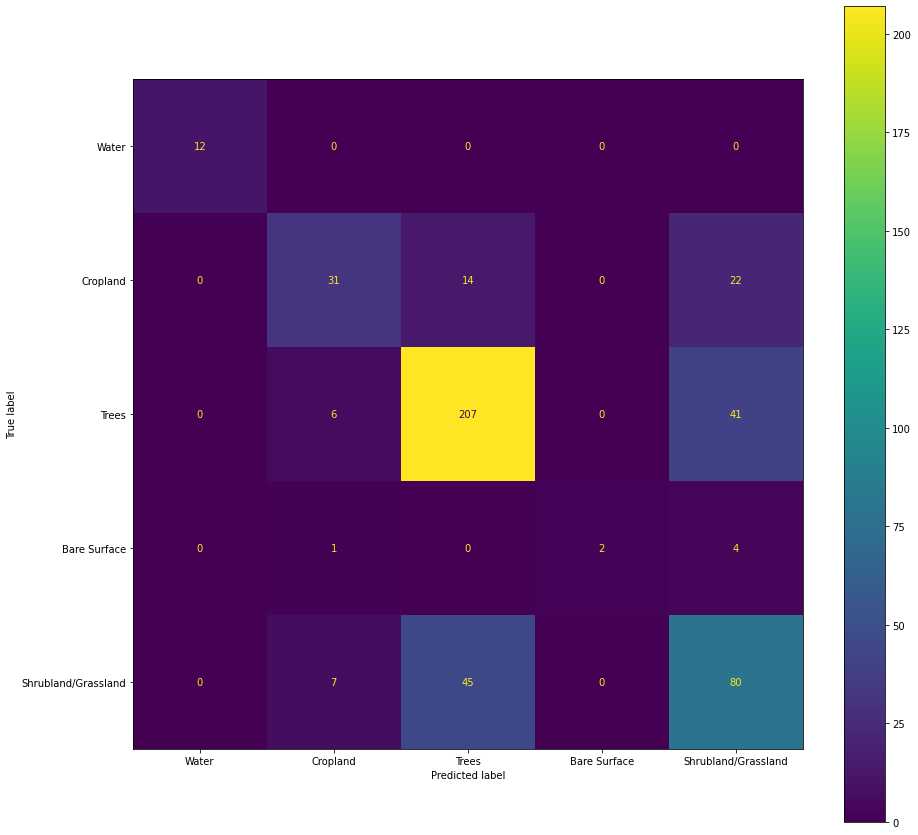

In [44]:
# evaluate model performance using cross validation
#model_train, model_test = model_selection.train_test_split(model_input,
#                                                           stratify=model_input[:, 0],
#                                                           train_size=0.8,
#                                                           random_state=0)
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
# skf=model_selection.StratifiedKFold(n_splits=5,shuffle=False) # stratified K-fold splitting
# skf=model_selection.StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=1) # stratified shuffle K-fold splitting
mean_acc=[]
# models=[]
for train_index, test_index in skf.split(model_input_selected[:,1:], model_input_selected[:,0]):
    print("Training data shape:", model_input_selected[train_index].shape)
    print("Testing data shape:", model_input_selected[test_index].shape)
    df_train=df_training_data.iloc[train_index]
    df_test=df_training_data.iloc[test_index]
# #     df_train=df_training_data.iloc[train_index].reset_index(drop=True)
# #     df_test=df_training_data.iloc[test_index].reset_index(drop=True)
#     # plot training data distribution in each class
#     class_counts=df_train[class_name].value_counts()
#     class_indices=class_counts.index
#     class_legends=[dict_map[class_indices[i]] for i in range(len(class_indices))]
#     plt.figure(figsize=(16,5))
#     ax=plt.bar(class_legends,height=class_counts.to_numpy())
#     plt.bar_label(ax)
#     plt.gca().set_ylabel('Number of training samples')
#     plt.gca().set_xlabel('Land cover class')
#     # plot testing data distribution in each class
#     class_counts=df_test[class_name].value_counts()
#     class_indices=class_counts.index
#     class_legends=[dict_map[class_indices[i]] for i in range(len(class_indices))]
#     plt.figure(figsize=(16,5))
#     ax=plt.bar(class_legends,height=class_counts.to_numpy())
#     plt.bar_label(ax)
#     plt.gca().set_ylabel('Number of training samples')
#     plt.gca().set_xlabel('Land cover class')
    # fit classifier to training data
#     rf = RandomForestClassifier(n_estimators=50,min_samples_leaf=1,bootstrap=True,max_samples=0.5,n_jobs=10) # set numbe of trees, bagging fraction
    #rf = RandomForestClassifier(n_estimators=127,min_samples_split=4,bootstrap=True) # set numbe of trees, bagging fraction
    # Train random forest model
    model_train=df_train.to_numpy()
    model_test=df_test.to_numpy()
    rf.fit(model_train[:,1:], model_train[:, 0])
#     models.append(rf)
#     # determine feature importance
#     order = np.argsort(rf.feature_importances_)[-20:]
#     plt.figure(figsize=(25,5))
#     plt.bar(x=np.array(df_training_data.columns[1:])[order],height=rf.feature_importances_[order])
#     plt.gca().set_ylabel('Importance', labelpad=10)
#     plt.gca().set_xlabel('Variable (most import 20)', labelpad=10)
    # evaluation
    predictions = rf.predict(model_test[:,1:])
    overall_acc=accuracy_score(model_test[:, 0],predictions)
    balanced_accuracy=balanced_accuracy_score(model_test[:, 0],predictions)
    kappa=cohen_kappa_score(predictions,model_test[:, 0])
    cm=confusion_matrix(model_test[:, 0], predictions)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[dict_map[rf.classes_[i]] for i in range(len(rf.classes_))])
    mean_acc.append(overall_acc*100)
    print('Overall accuracy: ',overall_acc*100,'%')
    print('Balanced accuracy: ',balanced_accuracy*100,'%')
    print('Kappa coefficient: ',kappa)
    print('Confusion matrix:\n')
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax)

print('mean accuracy: ',np.mean(mean_acc),'%')

In [4]:
rf.feature_importances_

array([0.00855427, 0.0269093 , 0.01244445, 0.00868514, 0.01436393,
       0.01512255, 0.008939  , 0.02349453, 0.00897535, 0.00682084,
       0.01355707, 0.01653728, 0.00965714, 0.02453032, 0.01398425,
       0.00917311, 0.01827338, 0.01143736, 0.00824887, 0.01755441,
       0.01000285, 0.00767377, 0.01154122, 0.01097788, 0.00760124,
       0.01016169, 0.00854948, 0.00750797, 0.01267513, 0.00917158,
       0.00813107, 0.01193808, 0.00772693, 0.00789513, 0.0112057 ,
       0.00931517, 0.00834849, 0.01360804, 0.01036015, 0.00800142,
       0.01196464, 0.01066693, 0.00853326, 0.01406031, 0.00787067,
       0.00927765, 0.01319642, 0.00979196, 0.01547312, 0.0253577 ,
       0.01325948, 0.01441448, 0.0251012 , 0.01343195, 0.01548341,
       0.02981669, 0.01886835, 0.02701544, 0.04709809, 0.01966429,
       0.01653163, 0.0229867 , 0.03252598, 0.03748138, 0.04965874,
       0.02081399])

In [5]:
model_train[:,1:]

array([[3.02171967e+02, 3.48216431e+02, 5.36120422e+02, ...,
        2.06266180e-01, 2.52238959e-01, 4.18145329e-01],
       [3.64887848e+02, 3.51148987e+02, 5.94733643e+02, ...,
        2.31387183e-01, 2.86542296e-01, 4.98303980e-01],
       [4.78689606e+02, 3.07998840e+02, 3.27766876e+02, ...,
        3.10811877e-01, 2.66713440e-01, 3.70895714e-01],
       ...,
       [5.21860291e+02, 4.09955627e+02, 5.50851990e+02, ...,
        1.81725696e-01, 2.09932223e-01, 5.35315633e-01],
       [2.06337265e+02, 3.17078419e+01, 1.17167992e+02, ...,
        8.07383478e-01, 7.58283079e-01, 7.96506763e-01],
       [1.26396545e+03, 1.51930664e+02, 1.23473228e+02, ...,
        4.20907766e-01, 4.65875149e-01, 6.51786745e-01]])

In [7]:
model_train[:, 0].astype(np.uint8)

array([ 1,  9,  9, ...,  2,  4, 10], dtype=uint8)

In [8]:
model_train[:, 0]

array([ 1.,  9.,  9., ...,  2.,  4., 10.])